# Importing Dependencies

In [ ]:
!pip install openpyxl
!pip install imutils
!pip install kaggle
!pip install patool

     |████████████████████████████████| 81kB 10.1MB/s 


In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os
import patoolib
#Added for VGG-16
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


In [ ]:
tf.random.set_seed(666)

# Dataset Preparation

In [ ]:
if not os.path.exists(os.getcwd() + "/kaggle.json"):
    files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download tawsifurrahman/covid19-radiography-database

# extract riceleafs dataset
if os.path.exists(os.getcwd() + "/input"):
  shutil.rmtree(os.getcwd() + "/input")
patoolib.extract_archive(os.getcwd() + "/covid19-radiography-database.zip", outdir = os.getcwd() + "/input/covid19-radiography-database")
os.remove(os.getcwd() + "/covid19-radiography-database.zip")

Saving kaggle.json to kaggle.json
 98% 732M/745M [00:05<00:00, 87.8MB/s]
100% 745M/745M [00:05<00:00, 133MB/s] 
patool: Extracting /content/covid19-radiography-database.zip ...
patool: running /usr/bin/7z x -o/content/input/covid19-radiography-database -- /content/covid19-radiography-database.zip
patool: ... /content/covid19-radiography-database.zip extracted to `/content/input/covid19-radiography-database'.


In [ ]:
output_class = 2 # 2/3 class
if output_class > 3 or output_class < 2:
    print("Undefined")

if os.path.exists(os.getcwd() + "/Dataset"):
    shutil.rmtree(os.getcwd() + "/Dataset")
os.mkdir(os.getcwd() + "/Dataset")
os.mkdir(os.getcwd() + "/Dataset/Normal")
os.mkdir(os.getcwd() + "/Dataset/COVID")
if output_class == 3:
    os.mkdir(os.getcwd() + "/Dataset/Pneumonia")

In [ ]:
df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx", engine = "openpyxl")
df_normal = df[(df["URL"] == "https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")]["FILE NAME"]

list_normal = np.array(df_normal)
list_normal[:] = [s.capitalize() for s in list_normal]
print(list_normal)

df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx", engine = "openpyxl")
df_covid = df[(df["URL"] == "https://sirm.org/category/senza-categoria/covid-19/") | (df["URL"] == "https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png") | (df["URL"] == "https://eurorad.org") | (df["URL"] == "https://github.com/armiro/COVID-CXNet") | (df["URL"] == "https://github.com/ieee8023/covid-chestxray-dataset")]["FILE NAME"]

list_covid = np.array(df_covid)
print(list_covid)

if output_class == 3:
    df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx", engine = "openpyxl")
    df_pneumonia = df["FILE NAME"]

    list_pneumonia = np.array(df_pneumonia)
    print(list_pneumonia)

['Normal-8852' 'Normal-8853' 'Normal-8854' ... 'Normal-10190'
 'Normal-10191' 'Normal-10192']
['COVID-1' 'COVID-2' 'COVID-3' ... 'COVID-1140' 'COVID-1141' 'COVID-1142']


In [ ]:
#dataset_covid = len(list_covid)
#dataset_normal = len(list_normal)
dataset_covid = 1000
dataset_normal = 1000
if output_class == 3:
    dataset_pneumonia = len(list_pneumonia)
    dataset_covid = 1000
    dataset_normal = 1000
    dataset_pneumonia = 1000

for x in range(dataset_normal):
    shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/{}{}".format(list_normal[x], ".png"), 
                    os.getcwd() + "/Dataset/Normal/{}{}".format(list_normal[x], ".png"))
for x in range(dataset_covid):
    shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/{}{}".format(list_covid[x], ".png"), 
                    os.getcwd() + "/Dataset/COVID/{}{}".format(list_covid[x], ".png"))
if output_class == 3:
    for x in range(dataset_pneumonia):
        shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/{}{}".format(list_pneumonia[x], ".png"), 
                        os.getcwd() + "/Dataset/Pneumonia/{}{}".format(list_pneumonia[x], ".png"))

print("Dataset")
print("Normal :", len(os.listdir(os.getcwd() + "/Dataset/Normal")))
print("COVID :", len(os.listdir(os.getcwd() + "/Dataset/COVID")))
if output_class == 3:
    print("Pneumonia :", len(os.listdir(os.getcwd() + "/Dataset/Pneumonia")))

Dataset
Normal : 1000
COVID : 1000


# Plot X-Rays

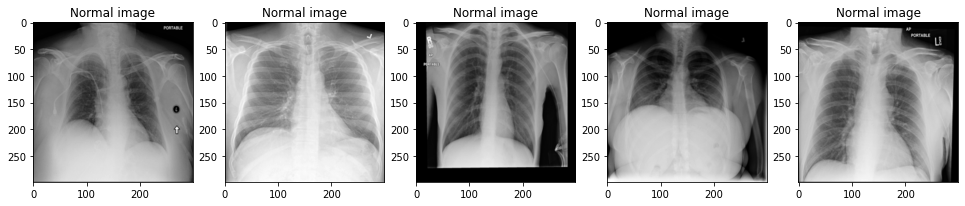

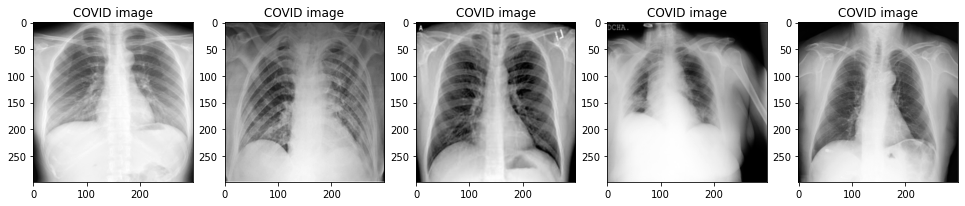

In [ ]:
directory = ["Normal", "COVID"]
if output_class == 3:
    directory = ["Normal", "COVID", "Pneumonia"]
for each in directory:
    plt.figure(figsize = (20, 10))
    currentFolder = os.getcwd() + "/Dataset/" + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = currentFolder + "/" + file
        img=mpimg.imread(fullpath)
        plt.subplot(3, 6, i+1)
        title = each + " image"
        plt.title(title)
        plt.imshow(img, cmap = 'gray')

# Data Preprocessing

In [ ]:
# set the initial learning rate, number of epochs, batch size and img dimension
learning_rate = 1e-3
epochs = 100
batch_size = 8
img_width, img_height = 224, 224
image_data_dir = os.getcwd() + "/Dataset"

# initialize the training and validation data augmentation
image_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    rotation_range = 45,
    fill_mode = "nearest")

# set as training data
train_generator = image_datagen.flow_from_directory(
    image_data_dir,
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size,
    subset = 'training')
# set as validation data
validation_generator = image_datagen.flow_from_directory(
    image_data_dir,
    target_size = (img_width, img_height),
    class_mode = 'binary',
    shuffle = False,
    batch_size = batch_size,
    subset = 'validation')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# VGG-19 Model

In [ ]:
#Create Vgg19

IMAGE_SIZE = [224,224]

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg.trainable = False

model = tf.keras.Sequential([
    vgg,
    tf.keras.layers.Flatten(),
    Dense(1, activation='sigmoid')
])

model.build(input_shape = (None, 224, 224, 3))

# our layers - you can add more if you want
#x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
#prediction = Dense(1, activation='sigmoid')(x)

# create a model object
#model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),
  metrics=['accuracy']
)




58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#early stopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

# train the head of the network
result = model.fit(train_generator,
                   steps_per_epoch = train_generator.samples // batch_size,
                   validation_data = validation_generator,
                   validation_steps = validation_generator.samples // batch_size,
                   callbacks = [monitor],
                   epochs = epochs)

Epoch 1/100
200/200 [==============================] - 59s 134ms/step - loss: 0.3874 - accuracy: 0.8300 - val_loss: 0.4414 - val_accuracy: 0.8175
Epoch 2/100
200/200 [==============================] - 27s 135ms/step - loss: 0.2523 - accuracy: 0.8938 - val_loss: 0.2656 - val_accuracy: 0.9050
Epoch 3/100
200/200 [==============================] - 27s 133ms/step - loss: 0.1925 - accuracy: 0.9219 - val_loss: 0.2715 - val_accuracy: 0.8925
Epoch 4/100
200/200 [==============================] - 27s 133ms/step - loss: 0.2205 - accuracy: 0.9056 - val_loss: 0.2775 - val_accuracy: 0.8925
Epoch 5/100
200/200 [==============================] - 27s 133ms/step - loss: 0.1716 - accuracy: 0.9287 - val_loss: 0.2819 - val_accuracy: 0.8850
Epoch 6/100
200/200 [==============================] - 26s 132ms/step - loss: 0.1416 - accuracy: 0.9450 - val_loss: 0.2249 - val_accuracy: 0.9050
Epoch 7/100
200/200 [==============================] - 26s 132ms/step - loss: 0.1522 - accuracy: 0.9419 - val_loss: 0.2355 -

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
vgg.trainable = True
model.summary()

model.compile(
  loss='binary_crossentropy',
  optimizer = Adam(learning_rate = 1e-5, decay = 1e-5 / epochs),
  metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 14,739,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = model.fit(train_generator,
                   steps_per_epoch = train_generator.samples // batch_size,
                   validation_data = validation_generator,
                   validation_steps = validation_generator.samples // batch_size,
                   callbacks = [monitor],
                   epochs = epochs)

Epoch 1/100
200/200 [==============================] - 38s 170ms/step - loss: 0.1554 - accuracy: 0.9331 - val_loss: 0.2251 - val_accuracy: 0.9050
Epoch 2/100
200/200 [==============================] - 34s 169ms/step - loss: 0.1529 - accuracy: 0.9394 - val_loss: 0.1887 - val_accuracy: 0.9200
Epoch 3/100
200/200 [==============================] - 34s 170ms/step - loss: 0.0925 - accuracy: 0.9650 - val_loss: 0.2506 - val_accuracy: 0.9150
Epoch 4/100
200/200 [==============================] - 34s 171ms/step - loss: 0.0801 - accuracy: 0.9712 - val_loss: 0.2072 - val_accuracy: 0.9200
Epoch 5/100
200/200 [==============================] - 34s 170ms/step - loss: 0.1096 - accuracy: 0.9569 - val_loss: 0.1832 - val_accuracy: 0.9300
Epoch 6/100
200/200 [==============================] - 34s 171ms/step - loss: 0.0436 - accuracy: 0.9825 - val_loss: 0.2528 - val_accuracy: 0.9075
Epoch 7/100
200/200 [==============================] - 34s 172ms/step - loss: 0.0736 - accuracy: 0.9756 - val_loss: 0.1844 -

# Plot Result

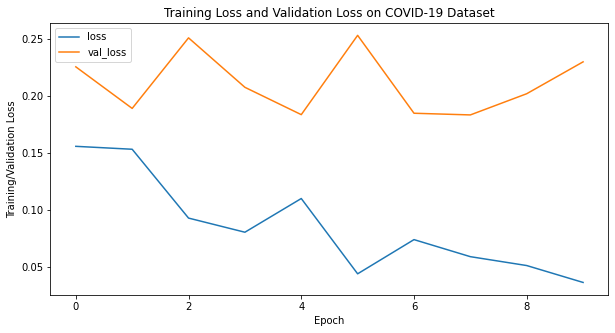

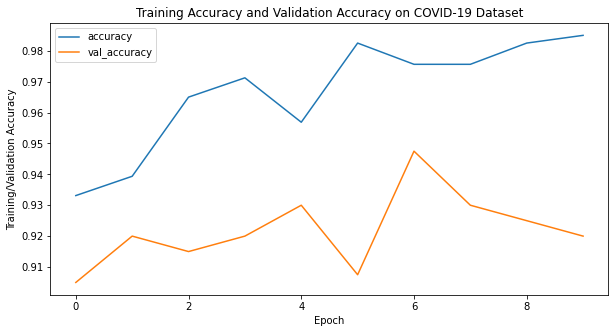

In [ ]:
# Plotting train_loss vs val_loss
plt.figure(figsize = (10, 5))
plt.plot(result.history["loss"], label = "loss")
plt.plot(result.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize = (10, 5))
plt.plot(result.history["accuracy"], label = "accuracy")
plt.plot(result.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = 'upper left')

# Evaluation

In [ ]:
print(model.evaluate(validation_generator))

50/50 [==============================] - 5s 109ms/step - loss: 0.1773 - accuracy: 0.9375
[0.17726939916610718, 0.9375]


In [ ]:
#Prediction:
if output_class == 2:
    predict = model.predict_classes(validation_generator)
elif output_class == 3:
    predict = model.predict(validation_generator)
    predict = np.argmax(predict, axis=1)
else:
    print("Undefined")
    
print('Confusion Matrix')
if output_class == 2:
    print(confusion_matrix(validation_generator.classes, predict))
elif output_class == 3:
    print(confusion_matrix(validation_generator.classes.argmax(axis=1), predict))
else:
    print("Undefined")
    
print('Classification Report')
target_names = ['Normal', 'COVID']
if output_class == 3:
    target_names = ['Normal', 'COVID', 'Pneumonia']
if output_class == 2:
    print(classification_report(validation_generator.classes, predict, target_names = target_names))
elif output_class == 3:
    print(classification_report(validation_generator.classes.argmax(axis=1), predict, target_names = target_names))
else:
    print("Undefined")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion Matrix
[[184  16]
 [ 12 188]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.94      0.92      0.93       200
       COVID       0.92      0.94      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [ ]:
print("Loss")
print(result.history["loss"])
print("Accuracy")
print(result.history["accuracy"])
print("Val_Loss")
print(result.history["val_loss"])
print("Val_Accuracy")
print(result.history["val_accuracy"])

Loss
[0.15541663765907288, 0.1528509259223938, 0.09247160702943802, 0.08007005602121353, 0.10963510721921921, 0.04359092563390732, 0.07358655333518982, 0.05862612649798393, 0.05083870887756348, 0.03601628541946411]
Accuracy
[0.9331250190734863, 0.9393749833106995, 0.9649999737739563, 0.9712499976158142, 0.9568750262260437, 0.9825000166893005, 0.9756249785423279, 0.9756249785423279, 0.9825000166893005, 0.9850000143051147]
Val_Loss
[0.22514429688453674, 0.18867723643779755, 0.250559002161026, 0.207185760140419, 0.18320946395397186, 0.25276002287864685, 0.1844337284564972, 0.1829662322998047, 0.20156310498714447, 0.22951768338680267]
Val_Accuracy
[0.9049999713897705, 0.9200000166893005, 0.9150000214576721, 0.9200000166893005, 0.9300000071525574, 0.9075000286102295, 0.9474999904632568, 0.9300000071525574, 0.925000011920929, 0.9200000166893005]
